<a href="https://colab.research.google.com/github/thisishasan/slda/blob/hasan/04_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import urllib.request
import zipfile
import os

# URL of the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

# Define column names based on the dataset's documentation
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

# Download and load the dataset
dataset_path = 'processed_cleveland.csv'
urllib.request.urlretrieve(url, dataset_path)

# Load dataset into a DataFrame
df = pd.read_csv(dataset_path, names=column_names)

# Handle missing values marked as '?'
df.replace('?', pd.NA, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')

# Basic dataset information
print("Dataset Information:")
df.info()

print("\nFirst 5 Rows of the Dataset:")
print(df.head())

print("\nSummary Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB

First 5 Rows of the Dataset:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  


--- Exploratory Data Analysis ---



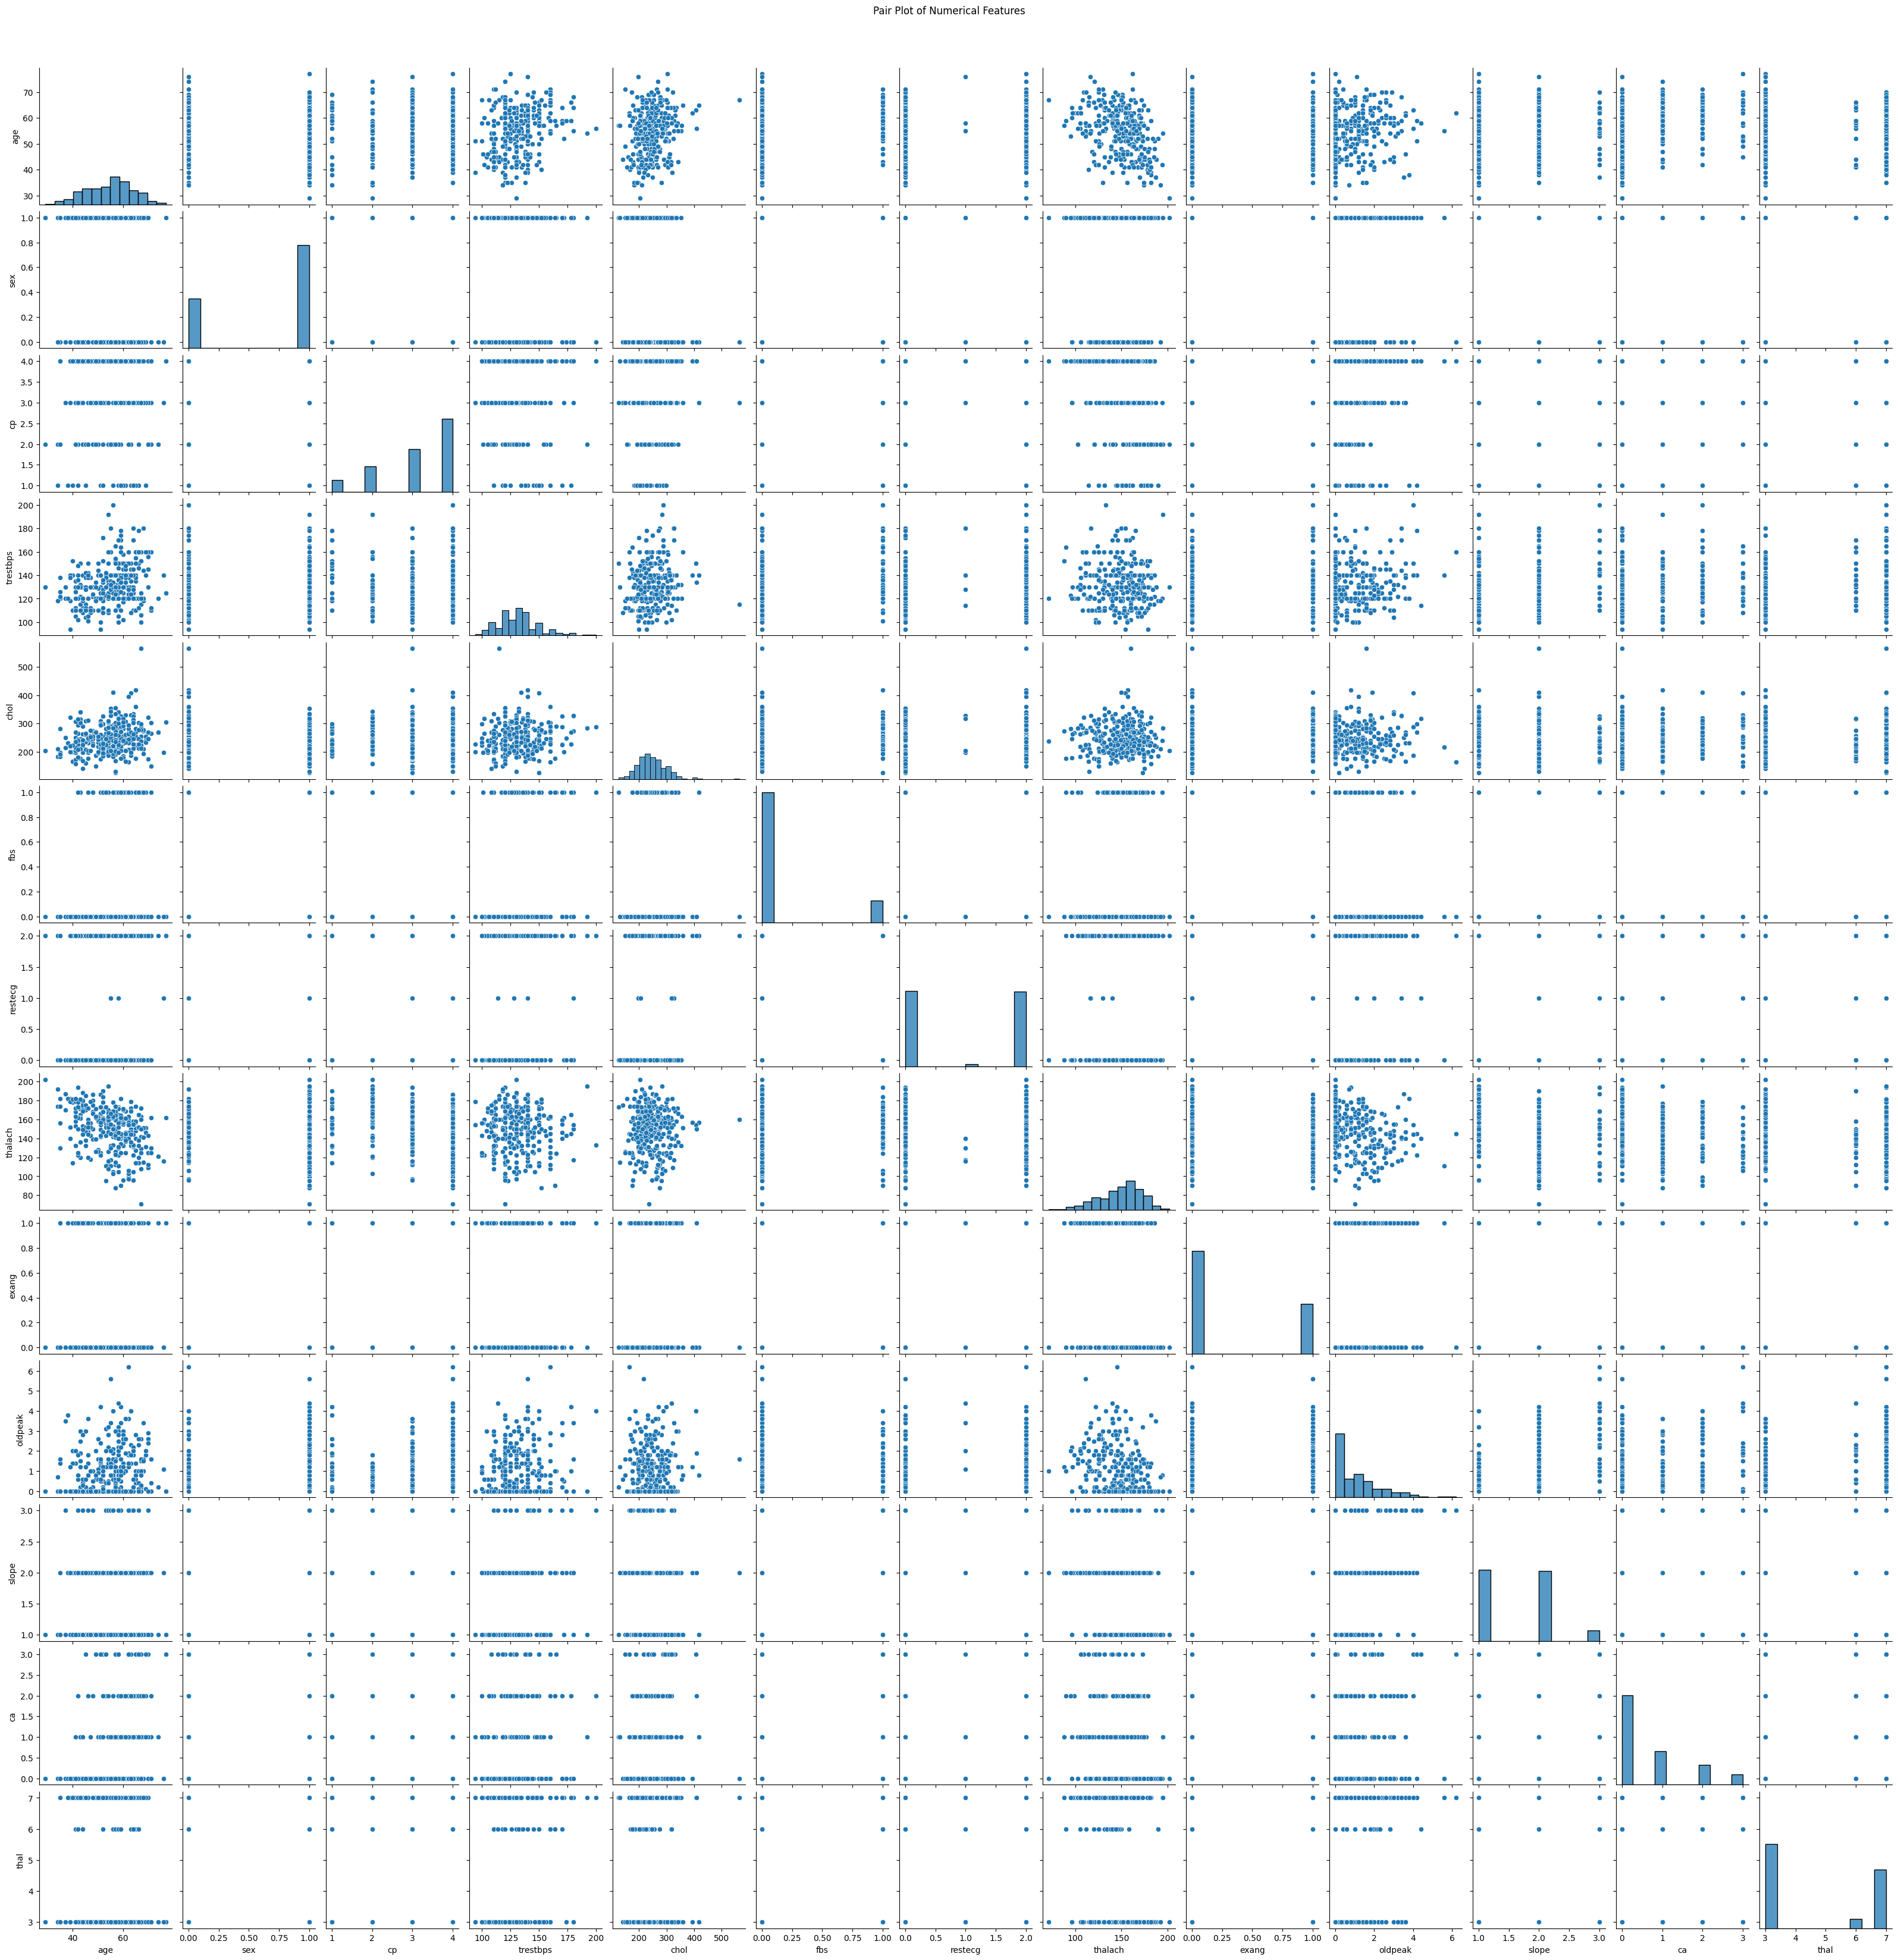

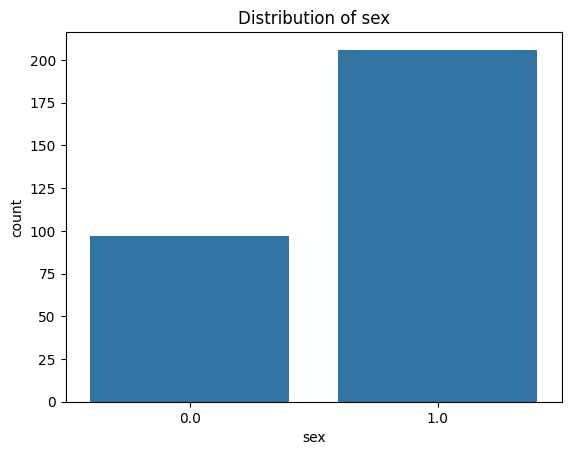

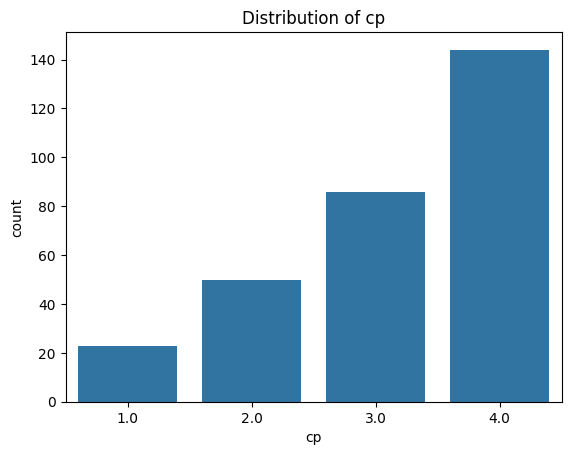

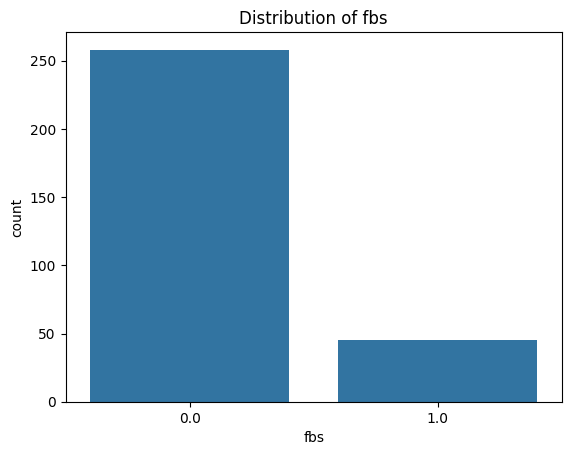

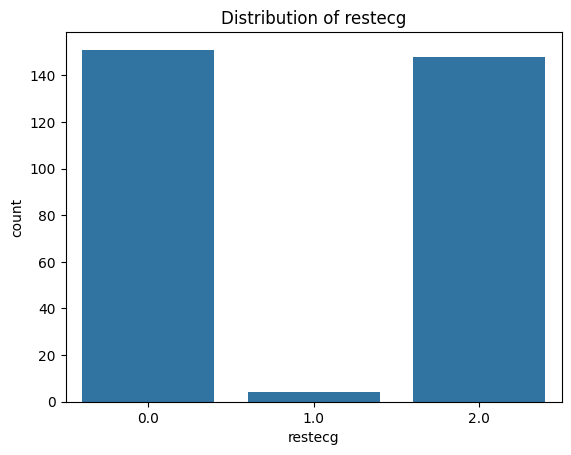

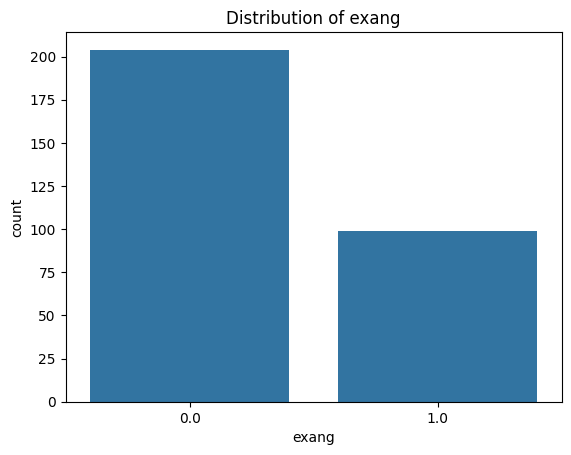

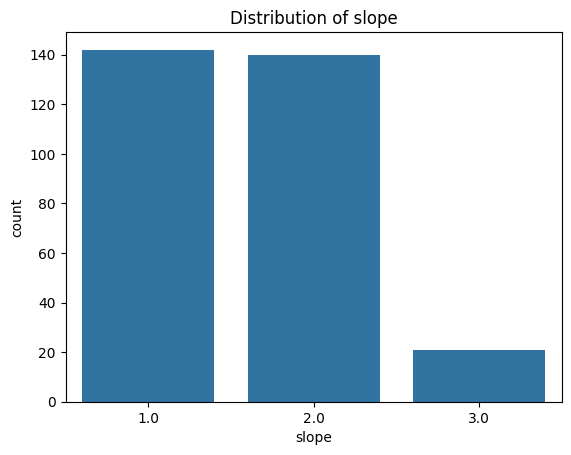

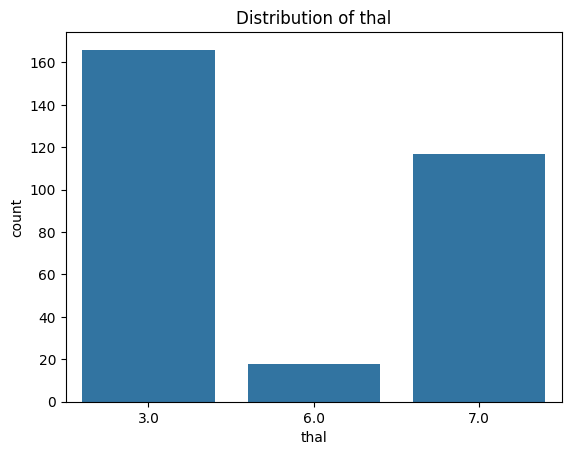

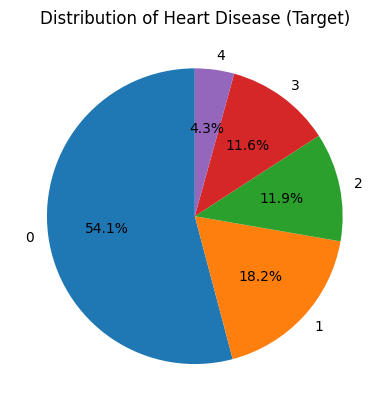

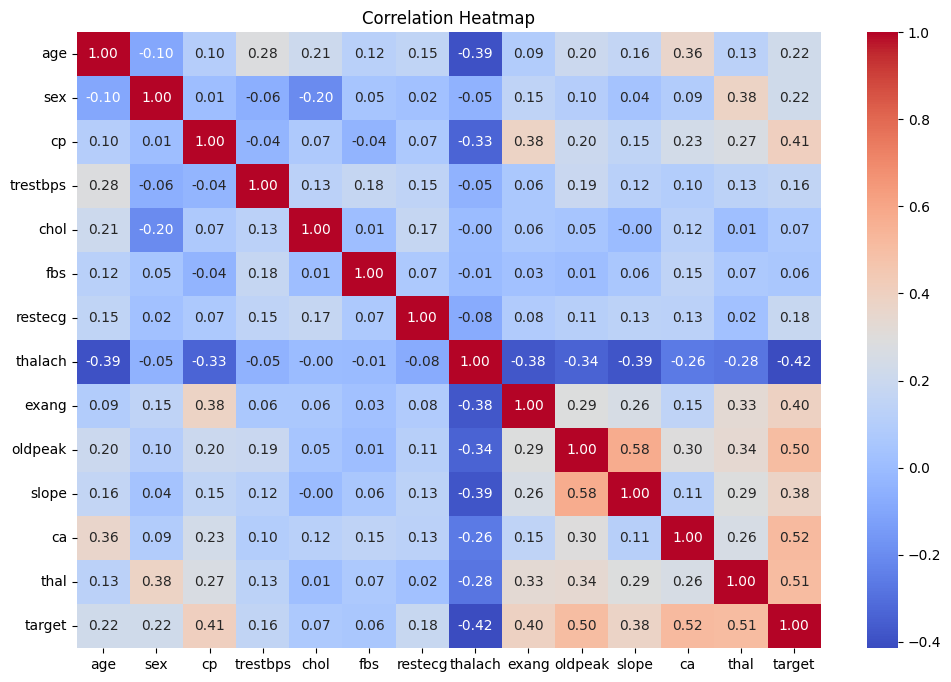

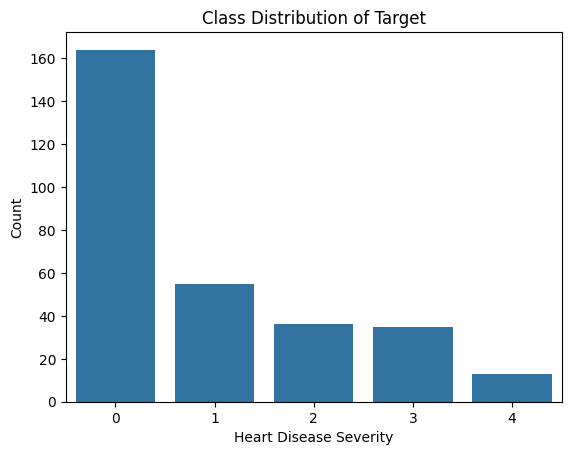


Correlation of features with Target:
 target      1.000000
ca          0.518909
thal        0.509923
oldpeak     0.504092
cp          0.407075
exang       0.397057
slope       0.377957
sex         0.224469
age         0.222853
restecg     0.183696
trestbps    0.157754
chol        0.070909
fbs         0.059186
thalach    -0.415040
Name: target, dtype: float64


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exploratory Data Analysis (EDA)
print("\n--- Exploratory Data Analysis ---\n")

# 1. Pair Plot for numerical features
sns.pairplot(df.drop(columns=['target']).dropna())
plt.suptitle('Pair Plot of Numerical Features', y=1.02)
plt.show()

# 2. Bar plots for categorical variables
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
for feature in categorical_features:
    sns.countplot(x=feature, data=df)
    plt.title(f'Distribution of {feature}')
    plt.show()

# 3. Pie chart for target distribution
target_counts = df['target'].value_counts()
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Heart Disease (Target)')
plt.show()

# 4. Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# 5. Class Distribution Analysis
sns.countplot(x='target', data=df)
plt.title('Class Distribution of Target')
plt.xlabel('Heart Disease Severity')
plt.ylabel('Count')
plt.show()

# 6. Correlation of Features with Target
correlations = df.corr()['target'].sort_values(ascending=False)
print("\nCorrelation of features with Target:\n", correlations)

In [8]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# --- Data Preprocessing ---
print("\n--- Data Preprocessing ---\n")

# Encode categorical variables
categorical_features_to_encode = ['cp', 'restecg', 'slope', 'thal']
df = pd.get_dummies(df, columns=categorical_features_to_encode, drop_first=True)

# Fill missing values with median
df.fillna(df.median(), inplace=True)

# Feature Scaling
scaler = StandardScaler()
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Splitting data into features and target
X = df.drop('target', axis=1)
y = df['target']

# Handle class imbalance using SMOTE if imbalance exists
if y.value_counts().min() / y.value_counts().max() < 0.5:
    print("Applying SMOTE to handle class imbalance...")
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)
    print("After SMOTE, class distribution:")
    print(y.value_counts())
else:
    print("Class distribution is balanced; SMOTE not applied.")

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nData Preprocessing Complete. Training and Testing sets are ready.")


--- Data Preprocessing ---

Applying SMOTE to handle class imbalance...
After SMOTE, class distribution:
target
0    164
2    164
1    164
3    164
4    164
Name: count, dtype: int64

Data Preprocessing Complete. Training and Testing sets are ready.


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np


# --- Model Building ---
print("\n--- Model Building and Evaluation ---\n")

# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "LDA": LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'),
    "QDA": QuadraticDiscriminantAnalysis(reg_param=0.1),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Train and evaluate models
predictions = {}
for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)
    evaluate_model(model, X_test, y_test)
    predictions[name] = model.predict(X_test)


--- Model Building and Evaluation ---


--- Logistic Regression ---
Accuracy: 0.5549
Precision: 0.5506
Recall: 0.5549
F1 Score: 0.5506
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.79      0.77        28
           1       0.41      0.37      0.39        35
           2       0.49      0.49      0.49        35
           3       0.57      0.48      0.52        33
           4       0.57      0.70      0.63        33

    accuracy                           0.55       164
   macro avg       0.56      0.56      0.56       164
weighted avg       0.55      0.55      0.55       164


--- LDA ---
Accuracy: 0.4512
Precision: 0.4602
Recall: 0.4512
F1 Score: 0.4536
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71        28
           1       0.32      0.34      0.33        35
           2       0.43      0.37      0.40        35
           3       0.34      0


--- Model Comparison using Confusion Matrix and ROC Curve ---



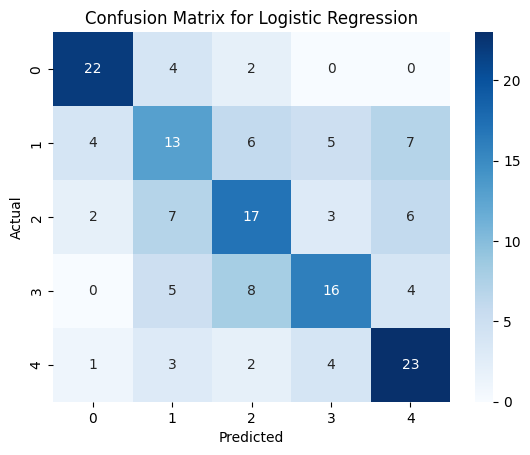

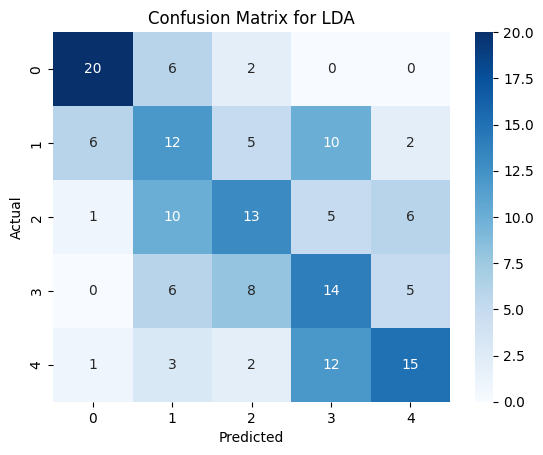

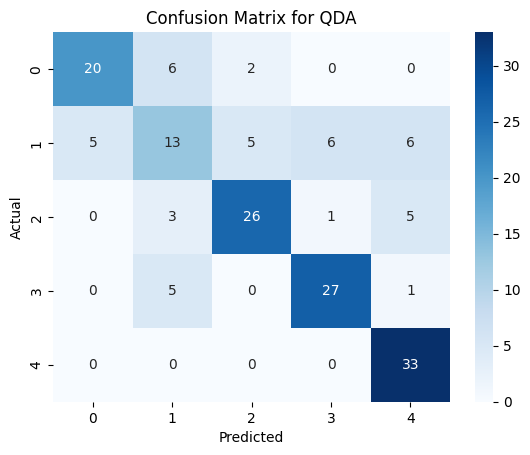

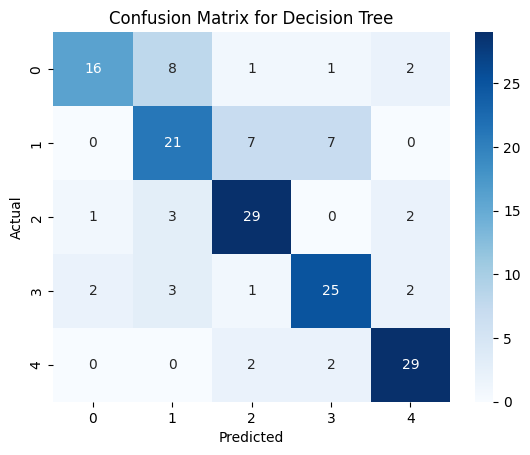

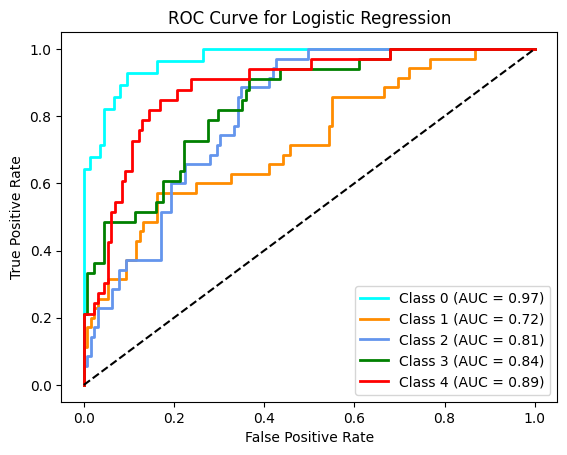

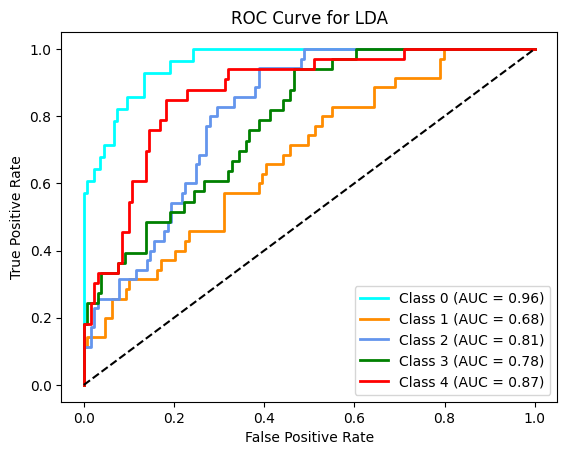

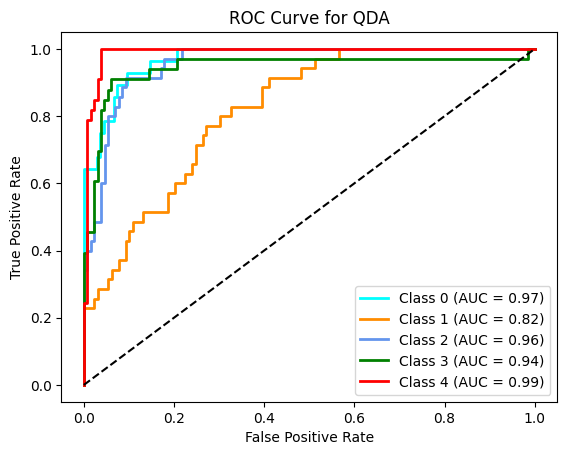

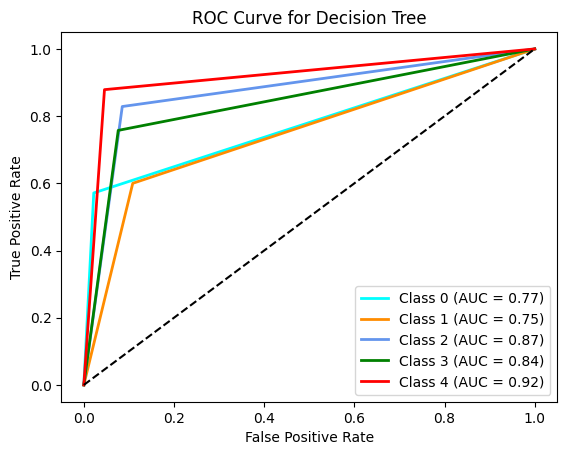


--- Impact of Feature Scaling ---

Feature scaling is crucial for models sensitive to feature magnitudes like Logistic Regression, LDA, and QDA. Models like Decision Trees are less affected. Scaling helped improve convergence and performance for linear models.


In [20]:
# --- Model Comparison ---
print("\n--- Model Comparison using Confusion Matrix and ROC Curve ---\n")

# Confusion Matrices
for name, y_pred in predictions.items():
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# ROC Curve and AUC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_binarized.shape[1]
for name, model in models.items():
    y_score = model.predict_proba(X_test)
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve for {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# --- Discussion on Feature Scaling Impact ---
print("\n--- Impact of Feature Scaling ---\n")
print("Feature scaling is crucial for models sensitive to feature magnitudes like Logistic Regression, LDA, and QDA. Models like Decision Trees are less affected. Scaling helped improve convergence and performance for linear models.")
